In [6]:
import sys
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.dataset import CityscapesKaggleDataset
from src.model import UNet

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Paths - Target your final refined weights
DATA_DIR = '../data/raw/cityscapes_data'
MODEL_PATH = '../models/cityscapes_refined.pth' 

print(f"✅ Validation Environment Ready on {device}")

✅ Validation Environment Ready on mps


In [7]:
# 1. Dataset and Loader
val_ds = CityscapesKaggleDataset(root_dir=DATA_DIR, split='val')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True)

# 2. Model Initialization
model = UNet(n_channels=3, n_classes=7).to(device)

# 3. Load the weights
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    print(f"✅ Successfully loaded refined weights from: {MODEL_PATH}")
else:
    print(f"❌ Error: Could not find weights at {MODEL_PATH}")

✅ Successfully loaded refined weights from: ../models/cityscapes_refined.pth


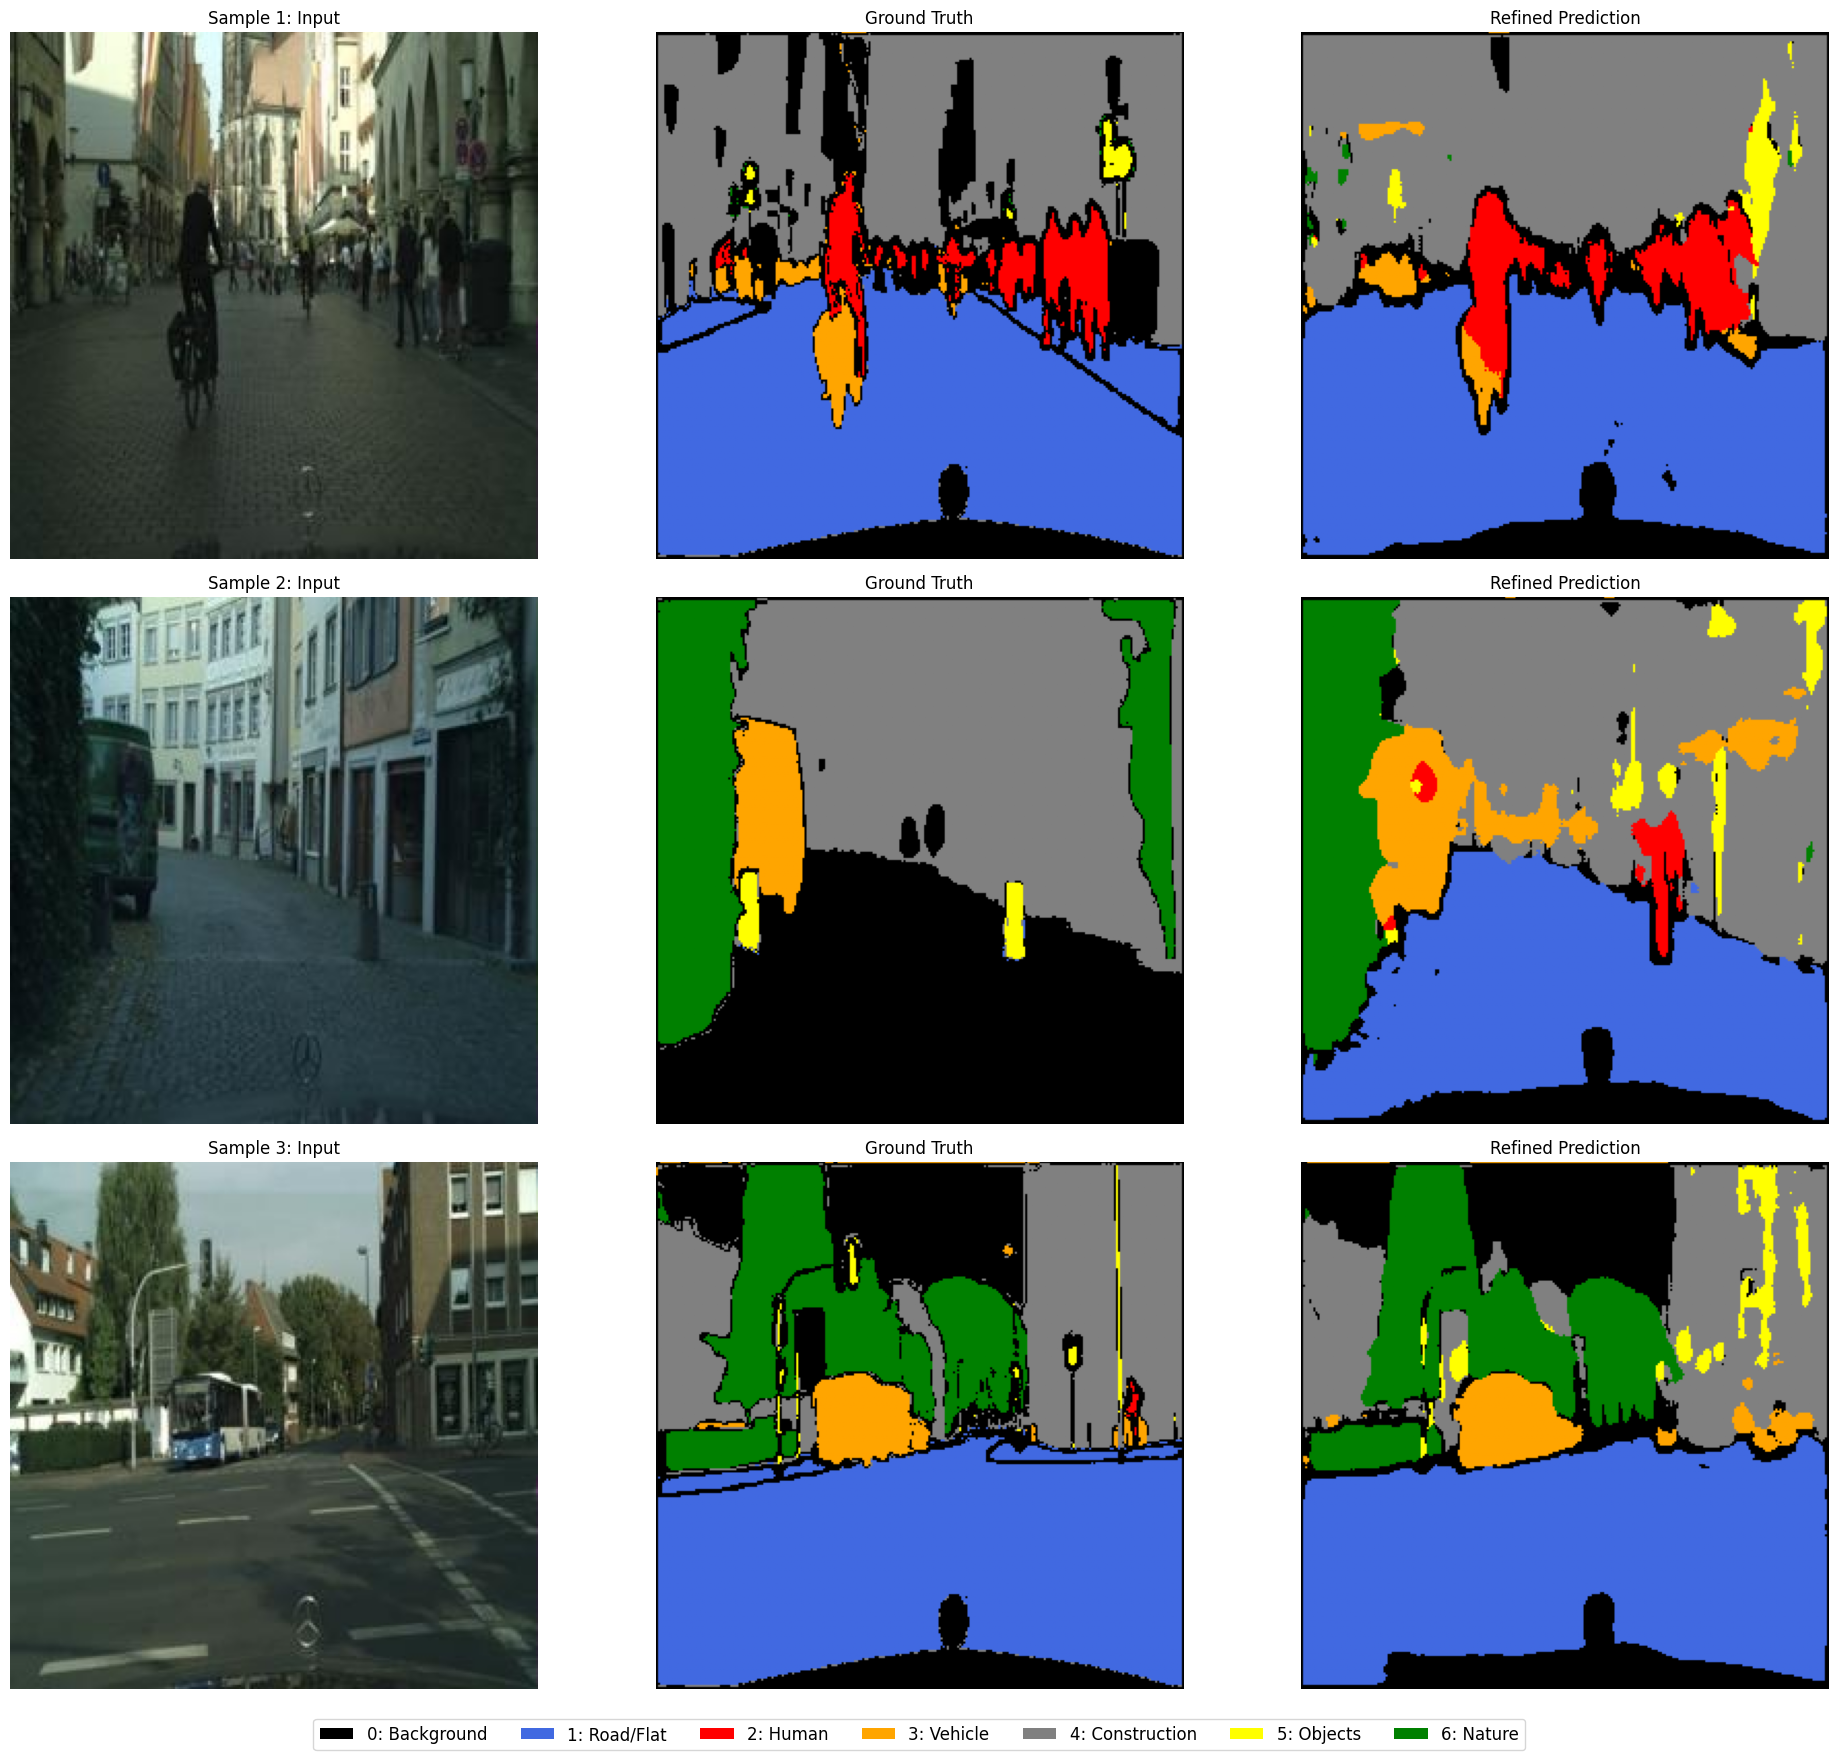

In [8]:
def validate_samples(num_samples=3):
    class_colors = ['black', 'royalblue', 'red', 'orange', 'gray', 'yellow', 'green']
    class_names = ['Background', 'Road/Flat', 'Human', 'Vehicle', 'Construction', 'Objects', 'Nature']
    custom_cmap = mcolors.ListedColormap(class_colors)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 6 * num_samples))
    
    with torch.no_grad():
        for i, (image, mask) in enumerate(val_loader):
            if i >= num_samples: break
            
            input_tensor = image.to(device)
            output = model(input_tensor)
            prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            
            axes[i, 0].imshow(image.squeeze(0).permute(1, 2, 0).numpy())
            axes[i, 0].set_title(f"Sample {i+1}: Input")
            
            axes[i, 1].imshow(mask.squeeze(0).numpy(), cmap=custom_cmap, vmin=0, vmax=6)
            axes[i, 1].set_title("Ground Truth")
            
            axes[i, 2].imshow(prediction, cmap=custom_cmap, vmin=0, vmax=6)
            axes[i, 2].set_title("Refined Prediction")
            
            for ax in axes[i]: ax.axis('off')

    legend_elements = [Patch(facecolor=class_colors[k], label=f'{k}: {class_names[k]}') for k in range(7)]
    fig.legend(handles=legend_elements, loc='lower center', ncol=7, bbox_to_anchor=(0.5, 0.02), fontsize='large')
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

# Run visual check
validate_samples(num_samples=3)

In [9]:
def get_detailed_metrics(model, dataloader, n_classes=7):
    model.eval()
    class_names = ['Background', 'Road', 'Human', 'Vehicle', 'Construction', 'Objects', 'Nature']
    total_inter = np.zeros(n_classes)
    total_union = np.zeros(n_classes)
    
    print("📊 Calculating final metrics across 500 validation images...")
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            for cls in range(n_classes):
                inter = ((preds == cls) & (masks == cls)).sum().item()
                union = ((preds == cls) | (masks == cls)).sum().item()
                total_inter[cls] += inter
                total_union[cls] += union

    ious = [total_inter[i] / total_union[i] if total_union[i] > 0 else 0 for i in range(n_classes)]
    results = pd.DataFrame({'Class': class_names, 'IoU Score': ious})
    return results

# Run and display analysis
final_stats = get_detailed_metrics(model, val_loader)
print("\n--- FINAL PERFORMANCE SUMMARY ---")
print(final_stats)
print(f"\nMean IoU: {final_stats['IoU Score'].mean():.4f}")

📊 Calculating final metrics across 500 validation images...


100%|██████████| 500/500 [00:19<00:00, 26.22it/s]


--- FINAL PERFORMANCE SUMMARY ---
          Class  IoU Score
0    Background   0.558915
1          Road   0.890269
2         Human   0.349737
3       Vehicle   0.680260
4  Construction   0.700712
5       Objects   0.152127
6        Nature   0.791849

Mean IoU: 0.5891
